<a href="https://colab.research.google.com/github/ghanbarzadeh/Course_MachineVision_2021/blob/master/CHW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
!wget -O 'sunflowers.jpg' 'https://i1.wp.com/cdn-images-1.medium.com/max/800/1*ZoJgAJm_JYlk2re4yqXPxw.jpeg?w=750&ssl=1'

--2021-11-04 09:49:41--  https://i1.wp.com/cdn-images-1.medium.com/max/800/1*ZoJgAJm_JYlk2re4yqXPxw.jpeg?w=750&ssl=1
Resolving i1.wp.com (i1.wp.com)... 192.0.77.2
Connecting to i1.wp.com (i1.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60604 (59K) [image/jpeg]
Saving to: ‘sunflowers.jpg’

sunflowers.jpg      100%[===================>]  59.18K  --.-KB/s    in 0.02s   

2021-11-04 09:49:41 (3.01 MB/s) - ‘sunflowers.jpg’ saved [60604/60604]



In [7]:
img = cv2.imread("/content/sunflowers.jpg",0) #gray scale conversion
img = img/255.0  #image normalization

In [14]:
# We will always use a filter size of 101*101 since computation is cheap!!
def LoG(sigma):
    d = 101
    filter = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            x = i-(d-1)/2
            y = j-(d-1)/2
            filter[i, j] = -1/np.pi/sigma**4*(1-(x**2+y**2)/2/sigma**2)*np.exp(-(x**2+y**2)/2/sigma**2)
    return filter

In [15]:
# %%time
k = 1.414
sigma_start = 1.0
def LoG_convolve(img):
    log_images = [] #to store responses
    for i in range(0,9):
        sigma =  sigma_start * np.power(k,i) #sigma 
        filter = LoG(sigma) #filter generation
        image = cv2.filter2D(img,-1,filter) # convolving image
        image = np.pad(image,((1,1),(1,1)),'constant') #padding 
        image = np.square(image) 
        log_images.append(image)
    return np.array(log_images) 
log_image = LoG_convolve(img)
#print(log_image_np.shape)

In [17]:
%%time
def detect_blob(log_image):
    co_ordinates = [] #to store coordinates
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image[:, i-1:i+2, j-1:j+2] #9*3*3 slice
            result = np.max(slice_img) #finding maximum
            if result >= 0.03: #threshold
                z, x, y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1, j+y-1, sigma_start * np.power(k, z))) #finding co-rdinates
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image)))

CPU times: user 1.04 s, sys: 21.9 ms, total: 1.06 s
Wall time: 1.05 s


In [ ]:
fig, ax = plt.subplots()
nh,nw = img.shape
ax.imshow(img, cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

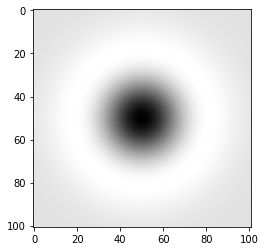

In [ ]:
plt.imshow(LoG(16), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


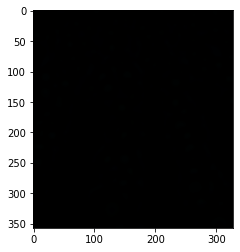

In [ ]:
 # convolving image

In [ ]:
a = np.random.rand(3, 4, 6)
a[1,3,4] = 0.98

In [ ]:
print(a)

[[[0.41329818 0.16222362 0.3144004  0.68929228 0.75027784 0.72091013]
  [0.20672982 0.03753518 0.1249617  0.3657533  0.05745658 0.02366756]
  [0.3135633  0.99140067 0.68059953 0.28263382 0.89305484 0.25247278]
  [0.71186016 0.17386476 0.75876408 0.22878059 0.1385024  0.31012001]]

 [[0.87014668 0.06440107 0.23760245 0.16655007 0.92134482 0.83733038]
  [0.87721187 0.46447011 0.68095434 0.34061883 0.42198794 0.80005601]
  [0.96975607 0.33837891 0.83034258 0.77085048 0.78661312 0.18023713]
  [0.58428774 0.647913   0.39936938 0.98591435 0.98       0.19470973]]

 [[0.51858885 0.82950642 0.7219306  0.51224297 0.78646014 0.66008095]
  [0.37619399 0.31763115 0.46449068 0.35212818 0.94094664 0.93746166]
  [0.13100415 0.4382076  0.8682654  0.99586004 0.21046964 0.01009961]
  [0.74597076 0.13798871 0.59342713 0.92591825 0.23079996 0.37473504]]]


In [ ]:
argmax(a)

63